In [1]:
import torch
import torch.nn as nn
model_id = "Qwen/Qwen3-0.6B" 
from transformers import AutoModelForCausalLM, AutoTokenizer
torch_model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [2]:
def rel_diff(a, b):
    x = np.abs(a-b) / (np.clip(np.abs(a), a_min=1, a_max=None))
    return x.mean(), x.max()

In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import sys
import ttml

In [4]:
torch_model

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

In [5]:
class InputOutputSaver(nn.Module):
    def __init__(self, wrapped_module):
        super().__init__()
        self.inputs = []
        self.outputs = []
        self.wrapped_module = wrapped_module
        
    def forward(self, *args, **kwargs):
        # Save both positional and keyword arguments
        self.inputs.append({
            'args': args,
            'kwargs': kwargs
        })
        
        # Forward pass
        output = self.wrapped_module(*args, **kwargs)
        
        # Save output (handles single values, tuples, lists, dicts, etc.)
        self.outputs.append(output)
        
        return output
    
    def clear_history(self):
        """Clear saved inputs and outputs"""
        self.inputs = []
        self.outputs = []
    
    def get_last_input(self):
        """Get the most recent input"""
        return self.inputs[-1] if self.inputs else None
    
    def get_last_output(self):
        """Get the most recent output"""
        return self.outputs[-1] if self.outputs else None
    
torch_model.model.layers[10].self_attn.q_norm = InputOutputSaver(torch_model.model.layers[10].self_attn.q_norm)
torch_model.model.layers[10].self_attn = InputOutputSaver(torch_model.model.layers[10].self_attn)
layer = torch_model.model.layers[10].self_attn
norm_layer = layer.wrapped_module.q_norm

In [6]:
OUTPUT_TOKENS = 1
WITH_SAMPLING = True
TEMPERATURE = 0.7
def generate_with_pytorch(torch_model, prompt_tokens):
    import time
    import torch.nn.functional as F
    from transformers import DynamicCache
    
    torch_model.eval()
    
    print("************************************")
    # Convert list to tensor and add batch dimension
    if isinstance(prompt_tokens, list):
        prompt_tokens = torch.tensor([prompt_tokens])
    
    start_time = time.time()
    
    # Initialize KV cache using the new DynamicCache API
    past_key_values = DynamicCache()
    input_ids = prompt_tokens
    
    with torch.no_grad():
        for i in range(OUTPUT_TOKENS):
            # Get model outputs with KV cache
            outputs = torch_model(
                input_ids=input_ids,
                past_key_values=past_key_values,
                use_cache=True
            )
            logits = outputs.logits
            past_key_values = outputs.past_key_values
            
            # Get logits for the last token
            next_token_logits = logits[:, -1, :]
            
            # Apply temperature and sample
            if WITH_SAMPLING and TEMPERATURE > 0:
                next_token_logits = next_token_logits / TEMPERATURE
                probs = F.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
            else:
                # Greedy sampling
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
            
            # Decode and print the token
            output = tokenizer.decode(next_token[0])
            print(output, end='', flush=True)
            
            # For next iteration, only pass the new token (KV cache handles the rest)
            input_ids = next_token
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    tokens_per_second = OUTPUT_TOKENS / elapsed_time
    
    print(f"\n************************************")
    print(f"Generated {OUTPUT_TOKENS} tokens in {elapsed_time:.2f} seconds")
    print(f"Performance: {tokens_per_second:.2f} tokens/second")
    print("************************************\n\n")
prompt_str = "starting with more efficient tokenizer"

prompt_tokens = tokenizer.encode(prompt_str)
generate_with_pytorch(torch_model, prompt_tokens)

************************************
 and
************************************
Generated 1 tokens in 0.31 seconds
Performance: 3.23 tokens/second
************************************




In [7]:
layer.wrapped_module.num_key_value_groups, layer.wrapped_module.head_dim

(2, 128)

In [8]:
import numpy as np
import torch
import torch.nn.functional as F
import sys
import ttml

torch.manual_seed(42)
np.random.seed(42)

In [9]:
layer.get_last_input()['kwargs']['hidden_states']

tensor([[[ 1.5430e-01,  7.2500e+00, -1.4282e-02,  ..., -1.8005e-03,
          -2.0996e-02, -2.6123e-02],
         [-4.9688e+00,  1.9875e+01,  6.4062e-01,  ..., -3.2031e-01,
           3.9844e-01, -4.9805e-01],
         [-7.2812e+00,  1.0250e+01, -3.2422e-01,  ..., -5.3906e-01,
           1.1797e+00,  5.9375e-01],
         [-4.6875e+00,  1.2438e+01,  7.1094e-01,  ..., -2.9688e-01,
          -2.7148e-01,  5.9766e-01],
         [-1.0859e+00,  1.7875e+01,  1.1426e-01,  ..., -1.4160e-01,
          -1.8555e-01,  3.6621e-02]]], dtype=torch.bfloat16)

In [10]:
layer.get_last_input()['kwargs']['cache_position']

tensor([0, 1, 2, 3, 4])

In [11]:
rope_theta = torch_model.config.rope_theta

In [12]:
import torch
import numpy as np

def generate_rope_embeddings(positions, head_dim, theta):
    """
    Generate RoPE sin/cos embeddings for given positions
    
    positions: tensor of position indices, e.g. [0, 1, 2]
    head_dim: dimension of each head (64 for Llama)
    theta: RoPE base frequency (500000 for Llama 3.2)
    
    Returns: (cos, sin) tensors of shape [1, len(positions), head_dim]
    """
    inv_freq = 1.0 / (theta ** (torch.arange(0, head_dim, 2, dtype=torch.float32) / head_dim))
    
    positions = positions.float()
    freqs = torch.outer(positions, inv_freq)
    
    emb = torch.cat([freqs, freqs], dim=-1)
    
    cos = emb.cos()
    sin = emb.sin()
    
    return cos.unsqueeze(0), sin.unsqueeze(0)

positions = layer.get_last_input()['kwargs']['cache_position'] # [0, 1, 2, ..]
cos_generated, sin_generated = generate_rope_embeddings(positions, layer.wrapped_module.head_dim, rope_theta)
print("Generated cos shape:", cos_generated.shape)
print("Generated sin shape:", sin_generated.shape)

cos_from_layer, sin_from_layer = layer.get_last_input()['kwargs']['position_embeddings']
print("\nFrom layer cos shape:", cos_from_layer.shape)
print("From layer sin shape:", sin_from_layer.shape)

print("\nCos match:", (cos_generated - cos_from_layer).abs().max())
print("Sin match:", (sin_generated - sin_from_layer).abs().max())

Generated cos shape: torch.Size([1, 5, 128])
Generated sin shape: torch.Size([1, 5, 128])

From layer cos shape: torch.Size([1, 5, 128])
From layer sin shape: torch.Size([1, 5, 128])

Cos match: tensor(0.0019)
Sin match: tensor(0.0019)


In [13]:
cos_from_layer.shape, cos_generated.shape

(torch.Size([1, 5, 128]), torch.Size([1, 5, 128]))

In [14]:
layer.get_last_input()['kwargs']['cache_position'].unsqueeze(1).shape

torch.Size([5, 1])

In [15]:
from transformers.models.qwen3.modeling_qwen3 import apply_rotary_pos_emb, Qwen3RMSNorm

In [16]:
def q3rmsnorm(hidden_states, weight, epsilon):
    input_dtype = hidden_states.dtype
    hidden_states = hidden_states.to(torch.float32)
    variance = hidden_states.pow(2).mean(-1, keepdim=True)
    hidden_states = hidden_states * torch.rsqrt(variance + epsilon)
    return weight * hidden_states.to(input_dtype)

In [17]:
batch, seq_len = 1, cos_from_layer.shape[1]
hidden_size = torch_model.config.hidden_size
num_heads = torch_model.config.num_attention_heads
num_kv_heads = torch_model.config.num_key_value_heads
head_dim = layer.wrapped_module.head_dim

hidden_pt = layer.get_last_input()['kwargs']['hidden_states']
q_weight_pt = layer.wrapped_module.q_proj.weight.data
k_weight_pt = layer.wrapped_module.k_proj.weight.data
v_weight_pt = layer.wrapped_module.v_proj.weight.data
o_weight_pt = layer.wrapped_module.o_proj.weight.data

q_weight_norm = layer.wrapped_module.q_norm.wrapped_module.weight.data
k_weight_norm = layer.wrapped_module.k_norm.weight.data

query = F.linear(hidden_pt, q_weight_pt).view(batch, seq_len, num_heads, head_dim)
key = F.linear(hidden_pt, k_weight_pt).view(batch, seq_len, num_kv_heads, head_dim)
value = F.linear(hidden_pt, v_weight_pt).view(batch, seq_len, num_kv_heads, head_dim)

query_norm = q3rmsnorm(query, q_weight_norm, torch_model.config.rms_norm_eps)
key_norm = q3rmsnorm(key, k_weight_norm, torch_model.config.rms_norm_eps)


query_pt = query_norm.transpose(1, 2)
key_pt = key_norm.transpose(1, 2)
value_pt = value.transpose(1, 2)

cos, sin = layer.get_last_input()['kwargs']['position_embeddings']

query_pt_emb, key_pt_emb = apply_rotary_pos_emb(query_pt, key_pt, cos, sin)

num_groups = num_heads // num_kv_heads

print(query_pt.shape, key_pt.shape, value_pt.shape)

key_pt_r = key_pt_emb.repeat_interleave(num_groups, dim=1)
value_pt_r = value_pt.repeat_interleave(num_groups, dim=1)

print(query_pt.shape, key_pt.shape, value_pt.shape)
attn_output_pt = F.scaled_dot_product_attention(query_pt_emb, key_pt_r, value_pt_r, is_causal=True)

attn_output_pt_reshaped = attn_output_pt.transpose(1, 2).contiguous().view(batch, seq_len, -1)
output_pt = F.linear(attn_output_pt_reshaped, o_weight_pt)
rel_diff(layer.get_last_output()[0].float().numpy(), output_pt.float().numpy())

torch.Size([1, 16, 5, 128]) torch.Size([1, 8, 5, 128]) torch.Size([1, 8, 5, 128])
torch.Size([1, 16, 5, 128]) torch.Size([1, 8, 5, 128]) torch.Size([1, 8, 5, 128])


(0.0, 0.0)

In [18]:
query_norm.shape

torch.Size([1, 5, 16, 128])

In [19]:
query_pt.shape

torch.Size([1, 16, 5, 128])

In [20]:
hidden_ttml = ttml.autograd.Tensor.from_numpy(
    hidden_pt.float().reshape(batch, 1, seq_len, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)

q_weight_ttml = ttml.autograd.Tensor.from_numpy(
    q_weight_pt.float().reshape(1, 1, num_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
k_weight_ttml = ttml.autograd.Tensor.from_numpy(
    k_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
v_weight_ttml = ttml.autograd.Tensor.from_numpy(
    v_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
o_weight_ttml = ttml.autograd.Tensor.from_numpy(
    o_weight_pt.float().reshape(1, 1, hidden_size, num_heads * head_dim).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)

q_proj = ttml.ops.matmul.matmul_op(hidden_ttml, q_weight_ttml, transpose_a=False, transpose_b=True)
k_proj = ttml.ops.matmul.matmul_op(hidden_ttml, k_weight_ttml, transpose_a=False, transpose_b=True)
v_proj = ttml.ops.matmul.matmul_op(hidden_ttml, v_weight_ttml, transpose_a=False, transpose_b=True)


#q_proj = ttml.ops.linear.linear_op(hidden_ttml, q_weight_ttml, q_weight_ttml)


2025-11-21 07:08:19.520 | info     |             UMD | Established cluster ETH FW version: 6.14.0 (topology_discovery_wormhole.cpp:359)
2025-11-21 07:08:19.523 | info     |          Device | Opening user mode device driver (tt_cluster.cpp:209)
2025-11-21 07:08:19.544 | info     |             UMD | Established cluster ETH FW version: 6.14.0 (topology_discovery_wormhole.cpp:359)
2025-11-21 07:08:19.583 | info     |             UMD | Established cluster ETH FW version: 6.14.0 (topology_discovery_wormhole.cpp:359)
2025-11-21 07:08:19.587 | info     |             UMD | Harvesting mask for chip 0 is 0x1 (NOC0: 0x1, simulated harvesting mask: 0x0). (cluster.cpp:413)
2025-11-21 07:08:19.620 | warning  |             UMD | init_detect_tt_device_numanodes(): Could not determine NumaNodeSet for TT device (physical_device_id: 0 pci_bus_id: 0000:04:00.0) (cpuset_lib.cpp:564)
2025-11-21 07:08:19.620 | warning  |             UMD | Could not find NumaNodeSet for TT Device (physical_device_id: 0 pci_bus

In [21]:
k_weight_norm.shape

torch.Size([128])

In [22]:
q_weight_pt.shape

torch.Size([2048, 1024])

In [23]:
def unpermute_proj_rows(w, n_heads):
    rows, cols = w.shape
    if rows % n_heads != 0:
        raise RuntimeError(f"unpermute_proj_rows: rows {rows} not divisible by n_heads {n_heads}")
    
    D = rows // n_heads
    if D % 2 != 0:
        raise RuntimeError(f"unpermute_proj_rows: rows per head {D} must be even")
    
    return w.view(n_heads, 2, D // 2, cols).transpose(1, 2).reshape(rows, cols)

def unpermute_norm_weights(w):
    total_size = w.shape[0]
    
    head_dim = total_size
    print(head_dim)
    if head_dim % 2 != 0:
        raise RuntimeError(f"unpermute_norm_weights: head_dim {head_dim} must be even")
    
    return w.view(2, head_dim // 2).transpose(0, 1).reshape(-1)

q_weight_unpermuted = unpermute_proj_rows(q_weight_pt.float(), num_heads)#q_weight_pt.float()
k_weight_unpermuted = unpermute_proj_rows(k_weight_pt.float(), num_kv_heads)#k_weight_pt.float()

q_weight_norm_unpermuted = unpermute_norm_weights(q_weight_norm.float())
k_weight_norm_unpermuted = unpermute_norm_weights(k_weight_norm.float())

hidden_ttml = ttml.autograd.Tensor.from_numpy(
    hidden_pt.float().reshape(batch, 1, seq_len, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
q_weight_ttml = ttml.autograd.Tensor.from_numpy(
    q_weight_unpermuted.reshape(1, 1, num_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
k_weight_ttml = ttml.autograd.Tensor.from_numpy(
    k_weight_unpermuted.reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
v_weight_ttml = ttml.autograd.Tensor.from_numpy(
    v_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
o_weight_ttml = ttml.autograd.Tensor.from_numpy(
    o_weight_pt.float().reshape(1, 1, hidden_size, num_heads * head_dim).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)

q_weight_norm_ttml = ttml.autograd.Tensor.from_numpy(
    q_weight_norm_unpermuted.reshape(1, 1, 1, head_dim).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)
k_weight_norm_ttml = ttml.autograd.Tensor.from_numpy(
    k_weight_norm_unpermuted.reshape(1, 1, 1, head_dim).numpy(),
    ttml.Layout.TILE,
    ttml.autograd.DataType.BFLOAT16
)

128
128


In [24]:
k_weight_norm.shape, q_weight_norm.shape

(torch.Size([128]), torch.Size([128]))

In [26]:
q_proj = ttml.ops.matmul.matmul_op(hidden_ttml, q_weight_ttml, transpose_a=False, transpose_b=True)
k_proj = ttml.ops.matmul.matmul_op(hidden_ttml, k_weight_ttml, transpose_a=False, transpose_b=True)
v_proj = ttml.ops.matmul.matmul_op(hidden_ttml, v_weight_ttml, transpose_a=False, transpose_b=True)

kv_proj = ttml.ops.concat([k_proj, v_proj], 3)
query_ttml, key_ttml, value_ttml = ttml.ops.multi_head_utils.grouped_heads_creation(
    q_proj, kv_proj, num_heads, num_kv_heads
)


query_norm_ttml = ttml.ops.rmsnorm.rmsnorm(query_ttml, q_weight_norm_ttml, torch_model.config.rms_norm_eps)
key_norm_ttml = ttml.ops.rmsnorm.rmsnorm(key_ttml, k_weight_norm_ttml, torch_model.config.rms_norm_eps)

causal_mask_binary = np.tril(np.ones((1, 1, seq_len, seq_len), dtype=np.float32))
mask_ttml = ttml.autograd.Tensor.from_numpy(
    causal_mask_binary, ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16
)

rope_params = ttml.ops.rope.build_rope_params(seq_len, head_dim, rope_theta)
query_ttml_emb = ttml.ops.rope.rope(query_norm_ttml, rope_params)
key_ttml_emb = ttml.ops.rope.rope(key_norm_ttml, rope_params)

attn_output_ttml = ttml.ops.multi_head_utils.scaled_dot_product_attention(
    query_ttml_emb, key_ttml_emb, value_ttml, mask_ttml
)

attn_output_ttml = ttml.ops.multi_head_utils.heads_fusion(attn_output_ttml)
output_ttml = ttml.ops.matmul.matmul_op(attn_output_ttml, o_weight_ttml, transpose_a=False, transpose_b=True)
    

In [27]:
query_ttml.shape(), key_ttml.shape(), value_ttml.shape()

([1, 16, 5, 128], [1, 8, 5, 128], [1, 8, 5, 128])

In [28]:
rel_diff(query.transpose(1,2).float().numpy(), query_ttml.to_numpy())

(0.79688823, 14.175476)

In [29]:
rel_diff(key.transpose(1,2).float().numpy(), key_ttml.to_numpy())

(0.8170519, 6.390625)

In [30]:
rel_diff(value.transpose(1,2).float().numpy(), value_ttml.to_numpy())

(0.00020026919, 0.007751938)

In [31]:
rel_diff(query_norm.transpose(1,2).float().numpy(), query_norm_ttml.to_numpy())

(1.1728133, 18.953125)

In [32]:
rel_diff(key_norm.transpose(1,2).float().numpy(), key_norm_ttml.to_numpy())

(1.4682119, 61.160156)

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math


def compare_tensors_with_viz(tensor1, tensor2, save_path="tensor_diff.png", show=True):
    tensor1 = tensor1.detach().cpu()
    tensor2 = tensor2.detach().cpu()
    
    if tensor1.shape != tensor2.shape:
        raise ValueError(f"Tensor shapes must match: {tensor1.shape} vs {tensor2.shape}")
    
    abs_diff = torch.abs(tensor1 - tensor2)
    max_abs = torch.maximum(torch.abs(tensor1), torch.abs(tensor2))
    relative_diff = abs_diff / (max_abs + 1.0)
    
    top5_values, top5_indices = torch.topk(relative_diff.flatten(), min(5, relative_diff.numel()))
    
    print("Top 5 relative differences:")
    for i, (val, idx) in enumerate(zip(top5_values, top5_indices)):
        multi_idx = np.unravel_index(idx.item(), relative_diff.shape)
        print(f"  {i+1}. Value: {val.item():.6e} at index {multi_idx}")
    
    diff_flat = relative_diff.flatten()
    n = diff_flat.numel()
    
    side = math.ceil(math.sqrt(n))
    total_size = side * side
    
    if n < total_size:
        padding = torch.zeros(total_size - n)
        diff_flat = torch.cat([diff_flat, padding])
    
    diff_2d = diff_flat.reshape(side, side)
    
    plt.figure(figsize=(10, 8))
    im = plt.imshow(diff_2d.numpy(), cmap='hot', interpolation='nearest', vmin=0, vmax=0.05)
    plt.colorbar(im, label='Relative Difference')
    plt.title(f'Tensor Relative Difference (scale: 0-5%)\nOriginal shape: {tensor1.shape}, Reshaped to: {diff_2d.shape}')
    plt.xlabel('Column')
    plt.ylabel('Row')
    
    #plt.savefig(save_path, dpi=150, bbox_inches='tight')
    #print(f"\nImage saved to: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()
    
    return relative_diff, diff_2d


In [34]:
# q shape: Shape([1, 1, 2048, 2048])
# kv shape: Shape([1, 1, 2048, 1024])
# query_with_heads shape: Shape([1, 32, 2048, 64])
# key_with_heads shape: Shape([1, 8, 2048, 64])
# value_with_heads shape: Shape([1, 8, 2048, 64])

In [35]:
query_norm_ttml.shape(), key_norm_ttml.shape(), value_ttml.shape()

([1, 16, 5, 128], [1, 8, 5, 128], [1, 8, 5, 128])

In [36]:
rel_diff(query_pt.float().numpy(), query_norm_ttml.to_numpy())

(1.1728133, 18.953125)

Top 5 relative differences:
  1. Value: 1.600985e+00 at index (0, 6, 1, 109)
  2. Value: 1.560261e+00 at index (0, 7, 1, 66)
  3. Value: 1.528369e+00 at index (0, 2, 2, 88)
  4. Value: 1.505263e+00 at index (0, 0, 2, 88)
  5. Value: 1.497608e+00 at index (0, 7, 2, 89)

Image saved to: tensor_diff.png


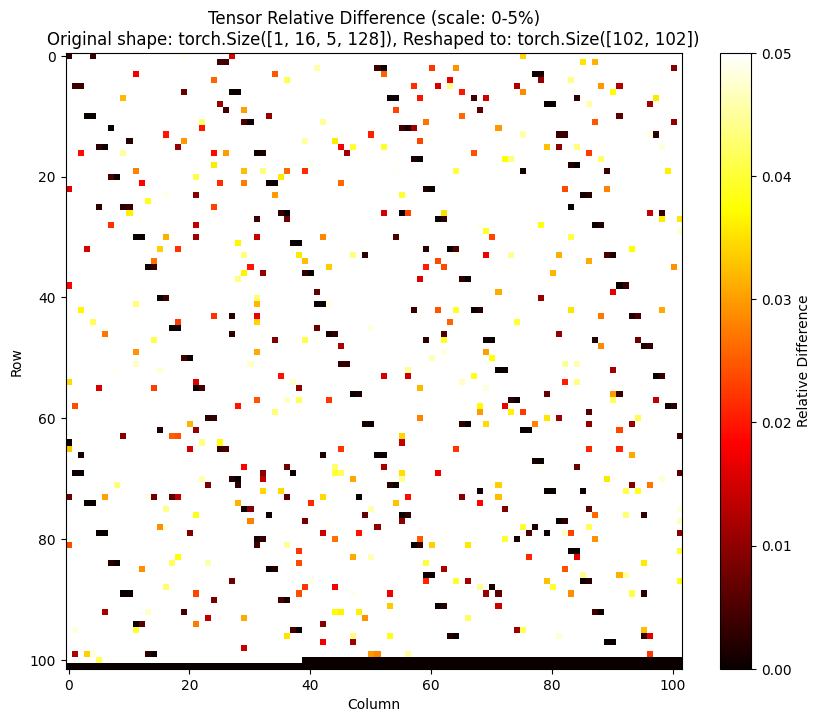

In [37]:
_ = compare_tensors_with_viz(query_pt.float(), torch.from_numpy(query_norm_ttml.to_numpy()))

Top 5 relative differences:
  1. Value: 1.586667e+00 at index (0, 1, 4, 124)
  2. Value: 1.538961e+00 at index (0, 2, 1, 124)
  3. Value: 1.538710e+00 at index (0, 7, 4, 125)
  4. Value: 1.511182e+00 at index (0, 1, 0, 125)
  5. Value: 1.492537e+00 at index (0, 4, 2, 1)

Image saved to: tensor_diff.png


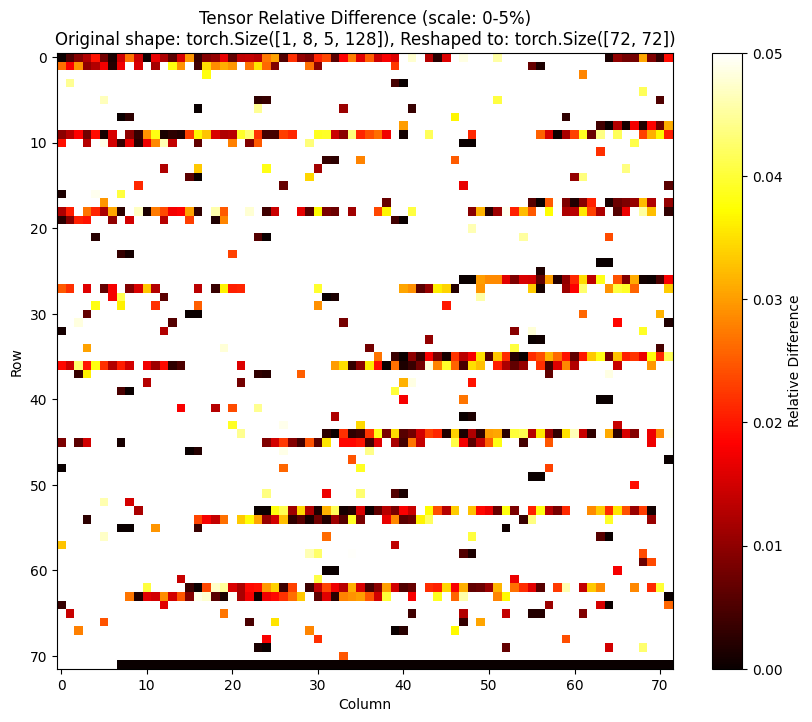

In [38]:
_ = compare_tensors_with_viz(key_pt.float(), torch.from_numpy(key_norm_ttml.to_numpy()))

Top 5 relative differences:
  1. Value: 4.901961e-03 at index (0, 2, 1, 125)
  2. Value: 4.405286e-03 at index (0, 4, 2, 123)
  3. Value: 3.984064e-03 at index (0, 4, 4, 41)
  4. Value: 3.891051e-03 at index (0, 1, 3, 34)
  5. Value: 3.875969e-03 at index (0, 2, 1, 12)

Image saved to: tensor_diff.png


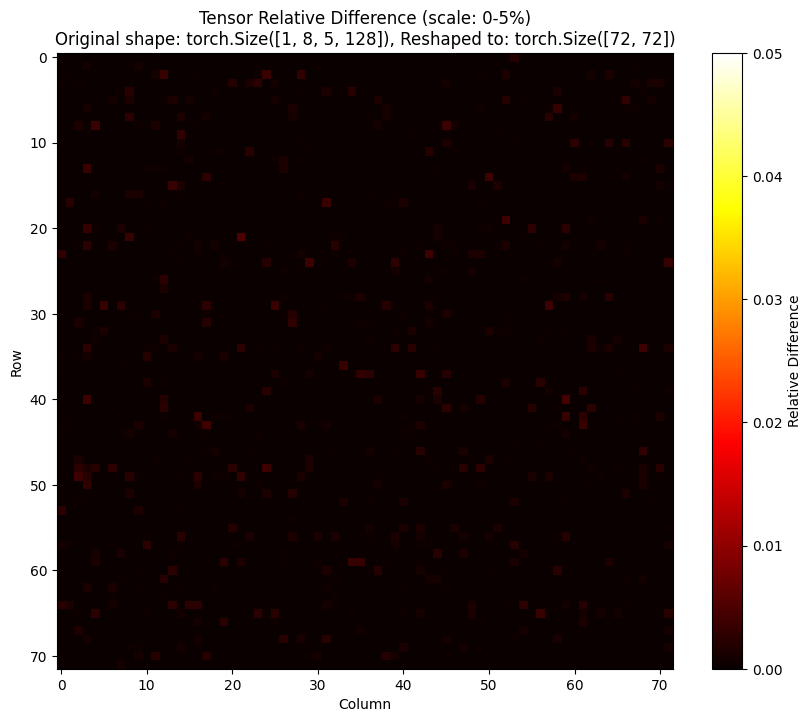

In [39]:
_ = compare_tensors_with_viz(value_pt.float(), torch.from_numpy(value_ttml.to_numpy()))

In [40]:
rel_diff(query_pt.float().numpy(), query_norm_ttml.to_numpy())

(1.1728133, 18.953125)

In [41]:
rel_diff(key_pt.float().numpy(), key_norm_ttml.to_numpy())

(1.4682119, 61.160156)

In [42]:
rel_diff(value_pt.float().numpy(), value_ttml.to_numpy())

(0.00020026919, 0.007751938)

In [48]:
rel_diff(output_pt.float().numpy(), output_ttml.to_numpy())

(0.0021956419, 0.038085938)

In [49]:
rel_diff(layer.get_last_output()[0].float().numpy(), output_ttml.to_numpy())

(0.0021956419, 0.038085938)

In [ ]:
torch_model.model.layers[10].inputs[0]['args']

In [ ]:
torch_model.model.layers[10].inputs[0]['args']

In [ ]:
torch_model.model.layers[10].inputs[0]['kwargs']

In [ ]:

torch_model.model.layers[10].outputs[0]

In [ ]:




def test_llama_attention():
    hidden_ttml = ttml.autograd.Tensor.from_numpy(
        hidden_pt.float().reshape(batch, 1, seq_len, hidden_size).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    
    q_weight_ttml = ttml.autograd.Tensor.from_numpy(
        q_weight_pt.float().reshape(1, 1, num_heads * head_dim, hidden_size).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    k_weight_ttml = ttml.autograd.Tensor.from_numpy(
        k_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    v_weight_ttml = ttml.autograd.Tensor.from_numpy(
        v_weight_pt.float().reshape(1, 1, num_kv_heads * head_dim, hidden_size).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    o_weight_ttml = ttml.autograd.Tensor.from_numpy(
        o_weight_pt.float().reshape(1, 1, hidden_size, num_heads * head_dim).numpy(),
        ttml.Layout.TILE,
        ttml.autograd.DataType.BFLOAT16
    )
    
    q_proj = ttml.ops.matmul.matmul_op(hidden_ttml, q_weight_ttml, transpose_a=False, transpose_b=True)
    k_proj = ttml.ops.matmul.matmul_op(hidden_ttml, k_weight_ttml, transpose_a=False, transpose_b=True)
    v_proj = ttml.ops.matmul.matmul_op(hidden_ttml, v_weight_ttml, transpose_a=False, transpose_b=True)
    
    print(f"\nLinear projection differences (PyTorch vs TTML):")
    print(f"Q: {np.abs(query_pt_flat.float().numpy().reshape(batch, 1, seq_len, -1) - q_proj.to_numpy()).max():.4f}")
    print(f"K: {np.abs(key_pt_flat.float().numpy().reshape(batch, 1, seq_len, -1) - k_proj.to_numpy()).max():.4f}")
    print(f"V: {np.abs(value_pt_flat.float().numpy().reshape(batch, 1, seq_len, -1) - v_proj.to_numpy()).max():.4f}")
    
    kv_proj = ttml.ops.concat([k_proj, v_proj], 3)
    query_ttml, key_ttml, value_ttml = ttml.ops.multi_head_utils.grouped_heads_creation(
        q_proj, kv_proj, num_heads, num_kv_heads
    )
    
    cos, sin = layer.get_last_input()['kwargs']['position_embeddings']
    rope_params = ttml.build_rope_params(seq_len, head_dim, 500000.0)
    cos_ttml_np = cos.float().numpy().reshape(1, 1, seq_len, head_dim)
    sin_ttml_np = sin.float().numpy().reshape(1, 1, seq_len, head_dim)
    rope_params.cos_cache = ttml.core.from_numpy(cos_ttml_np, ttml.autograd.ctx().get_device())
    rope_params.sin_cache = ttml.core.from_numpy(sin_ttml_np, ttml.autograd.ctx().get_device())
    rope_params.neg_cos_cache = ttml.core.from_numpy(cos_ttml_np, ttml.autograd.ctx().get_device())
    rope_params.neg_sin_cache = ttml.core.from_numpy(-sin_ttml_np, ttml.autograd.ctx().get_device())
    
    query_ttml = ttml.ops.rope.rope(query_ttml, rope_params)
    key_ttml = ttml.ops.rope.rope(key_ttml, rope_params)
    
    print(f"\nQ/K/V differences (PyTorch vs TTML after RoPE):")
    print(f"Q: {np.abs(query_pt_before_gqa.float().numpy() - query_ttml.to_numpy()).max():.4f}")
    print(f"K: {np.abs(key_pt_before_gqa.float().numpy() - key_ttml.to_numpy()).max():.4f}")
    print(f"V: {np.abs(value_pt_before_gqa.float().numpy() - value_ttml.to_numpy()).max():.4f}")
    
    causal_mask_binary = np.tril(np.ones((1, 1, seq_len, seq_len), dtype=np.float32))
    mask_ttml = ttml.autograd.Tensor.from_numpy(
        causal_mask_binary, ttml.Layout.TILE, ttml.autograd.DataType.BFLOAT16
    )
    
    attn_output_ttml = ttml.ops.multi_head_utils.scaled_dot_product_attention(
        query_ttml, key_ttml, value_ttml, mask_ttml
    )
    
    print(f"\nSDPA output: {np.abs(attn_output_pt.float().numpy() - attn_output_ttml.to_numpy()).max():.4f}")
    
    attn_output_ttml = ttml.ops.multi_head_utils.heads_fusion(attn_output_ttml)
    
    output_ttml = ttml.ops.matmul.matmul_op(attn_output_ttml, o_weight_ttml, transpose_a=False, transpose_b=True)
    
    abs_diff = np.abs(output_pt.float().numpy() - output_ttml.to_numpy().reshape(batch, seq_len, hidden_size))
    
    print(f"\nFinal output difference: Max={abs_diff.max():.2f}, Mean={abs_diff.mean():.4f}")
    print(f"\n✓ LlamaAttention implementation complete using TTML operations")
    